# Multiclass Brain Tumour Classification with Deep Learning

This notebook concerns the implementation of a convolutional neural network (CNN) applied to the challenge of classifying 

In [3]:
# Utility libraries
%matplotlib inline
from IPython.display import clear_output
import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt

# Deep learning and image management
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

## Defining the Behaviour of the Notebook and hence the Training of a Model

In [4]:
# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TRAINING_LOCATION = "..\\..\\assignment_kit\\dataset\\images\\"
TRAINING_LABEL_LOCATION = "..\\..\\assignment_kit\\dataset\\label.csv"

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TEST_LOCATION = "..\\..\\assignment_kit\\test_set\\images\\"
TEST_LABEL_LOCATION = "..\\..\\assignment_kit\\test_set\\label.csv"

# The directory in which to store pre-processed images, or the directoy in which
# pre-processed images will be found if they have already been pre-processed.
PROCESSED_TRAINING_LOCATION = "..\\..\\assignment_kit\\dataset\\processed_images_in_dirs\\"
PROCESSED_TEST_LOCATION = "..\\..\\assignment_kit\\test_set\\processed_images\\"

# Locations and directories to save data produced by the notebook
DATA_SAVE_LOCATION = "..\\CNN_saved_data\\"

CLASSES = ["no_tumor", "meningioma_tumor", "glioma_tumor", "pituitary_tumor"]

IMAGE_SIZE = (512, 512)
SCALING_FACTOR = 1/255

RANDOM_FLIP_MODE = "horizontal_and_vertical"
RANDOM_ROTATION_RANGE = (-0.5, 0.5) # As fractions of 2 \times \pi

BATCH_SIZE = 100
EPOCHS = 50
VALIDATION_SPLIT = 0.1
CONV2D_FILTER_1 = 32
CONV2D_FILTER_2 = 32
KERNEL_SIZE_1_DIM = 3
POOLING_SIZE = 4
PENULTIMATE_DENSE_SIZE = 128
ACTIVATION = "sigmoid"
FINAL_ACTIVATION = "softmax"

DROPOUT_RATES = [0.2, 0.4]
LEARNING_RATES = [0.01, 0.001]

## Preprocessing the Training Set

Errors are run into if the data set is passed to the network training algorithm in the same fasion as with the classical machine learning techniques implemented in other notebooks supplied with this work. Instead, tensorflow is able to infer the labels of various data points if they are stored in directories named after their labels. Therefore, two cells below, we do exactly that.

In [5]:
# Loads data into numpy array of strings.
# Header is skipped as given by skip_header = 1.
# The header in the expected file is "file_name" and "label".
# Therefore, indexing the 0'th element in a row references the filenames and indexing the 1'th element in a row references the label

data = np.genfromtxt(TRAINING_LABEL_LOCATION, delimiter = ',', dtype = str, skip_header = 1)

num_images = data.shape[0]

print("There are {} images in the dataset.".format(num_images))

There are 3000 images in the dataset.


In [5]:
# Images are sorted into directories corresponding to their label.
# This allows for more ergonomic use of the Keras utilities

if not (os.path.isdir(PROCESSED_TRAINING_LOCATION)):
    os.mkdir(PROCESSED_TRAINING_LOCATION)
    
    os.mkdir(PROCESSED_TRAINING_LOCATION + "no_tumor")
    os.mkdir(PROCESSED_TRAINING_LOCATION + "meningioma_tumor")
    os.mkdir(PROCESSED_TRAINING_LOCATION + "glioma_tumor")
    os.mkdir(PROCESSED_TRAINING_LOCATION + "pituitary_tumor")

    for i in range(num_images):
        image_string = "IMAGE_" + str(i).zfill(4)
        
        image_dir = data[i][1] + "\\" # Image directory corresponds to the label
        
        image = cv2.imread(TRAINING_LOCATION + image_string + ".jpg")
        
        # Convert colour image to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalise image such that pixel values are unsigned 8 bit
        processed_image = cv2.normalize(grey_image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        
        cv2.imwrite(PROCESSED_TRAINING_LOCATION + image_dir + image_string + ".jpg", processed_image)
        
        if (i % 100 == 0):
            clear_output(wait = True)
            print("{} / {} images processed.".format(i, num_images))
    
    clear_output(wait = True)
    print("Image processing done! {} images were processed!".format(num_images))
    
else:
    print("Data has already been pre-processed!")

Data has already been pre-processed!


## Providing Example of the Data Set

With the data sorted into directories, we now give an example of an MRI scane from each class below.

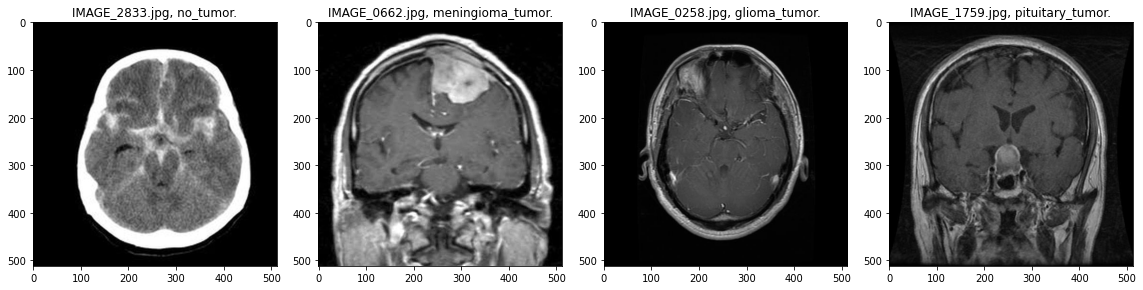

In [6]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

for i, label in enumerate(CLASSES):
    image_string = random.choice(os.listdir(PROCESSED_TRAINING_LOCATION + label + "\\"))
    
    ax[i].imshow(cv2.imread(PROCESSED_TRAINING_LOCATION + label + "\\" + image_string, cv2.IMREAD_GRAYSCALE), cmap = "gray")
    ax[i].set_title("{}, {}.".format(image_string, label))
    
plt.tight_layout()

## Preparing to Train

Next, we guide the tensorflow internals as to how we wish to pass training and validation sets. The training set is loaded from the directory structure just outlined. A fraction of this data is used for validation during the process as defined by `VALIDATION SPLIT`.

In [7]:
# Labels are not passed here as implementation seems to struggle with integer labels even though it's advertised as being okay to take them
# This is why the images are sorted into directories as above

training_set = keras.utils.image_dataset_from_directory(
    directory = "\\".join(PROCESSED_TRAINING_LOCATION.split("\\")[:-1]), # Need to provide this function with the directory ABOVE
    color_mode = "grayscale",  # Load images correctly! They have been pre-processed to be grayscale
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = False,           # Not needed as data is assumed to be in no particular order already, also makes label matching easier
    validation_split = VALIDATION_SPLIT,
    subset = "training"        # This is the training set after all
)

print("The classes found are {}.".format(training_set.class_names))

Found 3000 files belonging to 4 classes.
Using 2700 files for training.
The classes found are ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'].


In [8]:
validation_set = keras.utils.image_dataset_from_directory(
    directory = "\\".join(PROCESSED_TRAINING_LOCATION.split("\\")[:-1]), # Need to provide this function with the directory ABOVE
    color_mode = "grayscale",  # Load images correctly! They have been pre-processed to be grayscale
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = False,           # Not needed as data is assumed to be in no particular order already, also makes label matching easier
    validation_split = VALIDATION_SPLIT,
    subset = "validation"
)

print("The classes found are {}.".format(validation_set.class_names))

Found 3000 files belonging to 4 classes.
Using 300 files for validation.
The classes found are ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'].


## Creating Models with Various Hyperparameters

First, we define a function that is able to define, compile and train a model when passed a set of hyperparameters. In the case of this notebook, we explore the learning rate and the dropout rate. Remember, the Adam optimiser has the ability to internally update its learning rates - the learing rate we supply to this function is just a hard maximum. The dropout rate corresponds to the fraction of `neuron' connections that should randomly ignored.

Within this function, we also define layer to perform data augmentation. That is, it applied flips and rotations to images in the training set and produces new images from these transformations. Here we get two birds with one stone - we generate more data and it's more generalised!

In [9]:
def create_model(model_num, learning_rate, dropout_rate):
    
    # Perform an amount of data augmentation to be able to provide more and varied data
    data_aug = keras.Sequential([
        layers.RandomFlip(
            RANDOM_FLIP_MODE,
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
        ),
        layers.RandomRotation(RANDOM_ROTATION_RANGE)
    ])
    
    model = Sequential([
         # Data augmentation layer from before
        data_aug,
        
        # Rescales the image to float values costrained by [0, 1]. Last image dimension is 1 as only one colour channel is considered.
        layers.Rescaling(SCALING_FACTOR, input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        
        # First convolution layer + pooling layer pair. Some dropout occurs after the pooling layer.
        layers.Conv2D(
            filters = CONV2D_FILTER_1,
            kernel_size = KERNEL_SIZE_1_DIM,
            activation = ACTIVATION
        ),
        layers.MaxPooling2D(POOLING_SIZE),
        layers.Dropout(dropout_rate),
        
        # Second convolution layer + pooling layer pair. Some dropout occurs after the pooling layer.
        layers.Conv2D(
            filters = CONV2D_FILTER_2,
            kernel_size = KERNEL_SIZE_1_DIM,
            activation = ACTIVATION
        ),
        layers.MaxPooling2D(POOLING_SIZE),
        layers.Dropout(dropout_rate),
        
        # The 2D layers are flattened and fed through two one-dimensional dense layers to realise an output.
        layers.Flatten(),
        layers.Dense(PENULTIMATE_DENSE_SIZE, activation = ACTIVATION),
        layers.Dense(len(CLASSES), activation = FINAL_ACTIVATION)
    ])
    
    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = keras.losses.SparseCategoricalCrossentropy(),
        metrics = ["accuracy"]
    )
    
    print("==================================================")
    print("Training model number {}: Learning Rate= {}, Dropout Rate = {}.".format(model_num, learning_rate, dropout_rate))
    print("The model summary will be printed below.")
    print(model.summary())
    print("Training now begins below...")
    print("==================================================")
    
    history = model.fit(
        training_set,
        validation_data = validation_set,
        epochs = EPOCHS,
        verbose = 1 # Show progress
    )
    
    # Save model and its history for later evaluation
    if not (os.path.isdir(DATA_SAVE_LOCATION)):
        os.mkdir(DATA_SAVE_LOCATION)

    model.save(DATA_SAVE_LOCATION + "model_{}.h5".format(model_num))
    
    # Save model training metrics
    np.save(DATA_SAVE_LOCATION + "model_{}_accuracy.npy".format(model_num), history.history["accuracy"])
    np.save(DATA_SAVE_LOCATION + "model_{}_val_accuracy.npy".format(model_num), history.history["val_accuracy"])
    np.save(DATA_SAVE_LOCATION + "model_{}_loss.npy".format(model_num), history.history["loss"])
    np.save(DATA_SAVE_LOCATION + "model_{}_val_loss.npy".format(model_num), history.history["val_loss"])

In [10]:
# Iterate over trial hyperparameters to tune (Cross validation is not used due to computational restrictions)
model_num = 0
for learning_rate in LEARNING_RATES:
    for dropout_rate in DROPOUT_RATES:
        create_model(model_num, learning_rate, dropout_rate)
        model_num += 1
        print("-------------------- {} / {} models trained --------------------".format(model_num, len(LEARNING_RATES) * len(DROPOUT_RATES)))

Training model number 0: Learning Rate= 0.01, Dropout Rate = 0.2.
The model summary will be printed below.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 512, 512, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 51, 51, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 32)        9248      
                                                                 
 max_pooling2

## Test the Trained Models

Next, with the models trained, we can quantify their performance. First we investigate how their loss functions and accuracies were optimised during the training process. Afterwards, we test the CNNs with a test set to attempt to quantify any overfitting or inaccuracies.

Unfortunately, as outlined in the supplementary report, a successful model was not able to be trained. Even with tweaks to the learing rate and other hyperparameters, the models were just not converging on a predictive minimum. A good number of models were left to train on local available hardware overnight for a few nights - but no success. In efforts to not be impeded by the contraints of non-GPU accelerated local hardware specifications, computing instances were spun up on the AWS cloud platform. However, due to cost restrictions and account restrictions out of control of a user, a GPU instance could not be accessed. A powerful CPU focussed instance with a large memory volume attached was used to train a number of models however cost, ease of use and other factors eventually made this solution to the hardware problem redundant. It was quicker - but not by enough.

Hopefully this notebook gives a reader a good intuition as what was intended.

If a successful model were to be trained, code would have been written below to evaluate the cost function and accuracy, on both the training and validation sets, during the CNN training process. That is, each of the four quantities mentioned would have been sampled at every epoch.

Then, eventually, the model would have been evaluated on the supplied testing set.